# Bailey's Deeping Learning Assignment 3

## Network 1: Basic CNN

In [19]:
# Create basic CNN model using Immagenette dataset
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics


class CnnModel(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        # use cnn
        self.estimator = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

        self.accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )

    def forward(self, x):
        return self.estimator(x)  # No need to reshape here!

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        acc = self.accuracy(y_hat, y)

        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_accuracy", acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        # Ensure values are logged at the end of an epoch
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", self.accuracy, on_epoch=True, prog_bar=True, logger=True)


    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        self.log("test_accuracy", self.accuracy)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [20]:
from torchvision import transforms
from torchvision.datasets import Imagenette
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint


# prepare data for cnn taking 64x64 greyscale images
cnn_train_transforms = transforms.Compose(
    [
        transforms.CenterCrop(160),
        transforms.Resize(64),
        transforms.Grayscale(),  # Move this before ToTensor()
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Adjust normalization for 1 channel
    ]
)

cnn_test_transforms = transforms.Compose(
    [
        transforms.CenterCrop(160),
        transforms.Resize(64),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
cnn_train_dataset = Imagenette(
    "data/imagenette/train/",
    split="train",
    size="160px",
    download=False,
    transform=cnn_train_transforms,
)

# Use 10% of the training set for validation
cnn_train_set_size = int(len(cnn_train_dataset) * 0.9)
cnn_val_set_size = len(cnn_train_dataset) - cnn_train_set_size

seed = torch.Generator().manual_seed(42)
cnn_train_dataset, cnn_val_dataset = torch.utils.data.random_split(
    cnn_train_dataset, [cnn_train_set_size, cnn_val_set_size], generator=seed
)
cnn_val_dataset.dataset.transform = cnn_test_transforms

# Use DataLoader to load the dataset
cnn_train_loader = torch.utils.data.DataLoader(
    cnn_train_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=True,
    persistent_workers=True,
)
cnn_val_loader = torch.utils.data.DataLoader(
    cnn_val_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=False,
    persistent_workers=True,
)

# Configure the test dataset
cnn_test_dataset = Imagenette(
    "data/imagenette/test/",
    split="val",
    size="160px",
    download=False,
    transform=cnn_test_transforms,
)

cnn_model = CnnModel()

# Add EarlyStopping
cnn_early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)

# Configure Checkpoints
cnn_checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

In [21]:
# Train cnn model
torch.set_float32_matmul_precision("medium")
trainer = L.Trainer(
    callbacks=[cnn_early_stop_callback, cnn_checkpoint_callback], max_epochs=100
)
trainer.fit(
    model=cnn_model, train_dataloaders=cnn_train_loader, val_dataloaders=cnn_val_loader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | estimator | Sequential         | 2.1 M  | train
1 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.470     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 67/67 [00:02<00:00, 30.95it/s, v_num=18, train_loss_step=0.167, train_accuracy_step=0.959, val_loss=1.750, val_accuracy=0.930, train_loss_epoch=0.146, train_accuracy_epoch=0.970] 


In [22]:
# Evaluate the model on the test set
cnn_test_loader = torch.utils.data.DataLoader(
    cnn_test_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=False,
    persistent_workers=True,
)

trainer.test(model=cnn_model, dataloaders=cnn_test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 31/31 [00:00<00:00, 49.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5638216733932495     │
│         test_loss         │    1.8854992389678955     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.5638216733932495, 'test_loss': 1.8854992389678955}]

## Network 2: ResNet 18

In [24]:
# Create a ResNet model using the Imagenette dataset
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics


class ResNetModel(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        # Use pretrained ResNet18 with the updated weights argument
        self.estimator = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Modify the final layer to match the number of classes
        self.estimator.fc = nn.Linear(self.estimator.fc.in_features, num_classes)

        self.accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )

    def forward(self, x):
        return self.estimator(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        acc = self.accuracy(y_hat, y)

        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_accuracy", acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        # Ensure values are logged at the end of an epoch
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", self.accuracy, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        self.log("test_accuracy", self.accuracy)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [25]:
from torchvision import transforms
from torchvision.datasets import Imagenette
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

# prepare data for ResNet 18 model taking 64x64 RGB images
resnet_train_transforms = transforms.Compose(
    [
        transforms.CenterCrop(160),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)

resnet_test_transforms = transforms.Compose(
    [
        transforms.CenterCrop(160),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)

resnet_train_dataset = Imagenette(
    "data/imagenette/train/",
    split="train",
    size="160px",
    download=False,
    transform=resnet_train_transforms,
)

# Use 10% of the training set for validation
resnet_train_set_size = int(len(resnet_train_dataset) * 0.9)
resnet_val_set_size = len(resnet_train_dataset) - resnet_train_set_size

seed = torch.Generator().manual_seed(42)
resnet_train_dataset, resnet_val_dataset = torch.utils.data.random_split(
    resnet_train_dataset, [resnet_train_set_size, resnet_val_set_size], generator=seed
)
resnet_val_dataset.dataset.transform = resnet_test_transforms

# Use DataLoader to load the dataset
resnet_train_loader = torch.utils.data.DataLoader(
    resnet_train_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=True,
    persistent_workers=True,
)
resnet_val_loader = torch.utils.data.DataLoader(
    resnet_val_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=False,
    persistent_workers=True,
)

# Configure the test dataset
resnet_test_dataset = Imagenette(
    "data/imagenette/test/",
    split="val",
    size="160px",
    download=False,
    transform=resnet_test_transforms,
)

resnet_model = ResNetModel()

# Add EarlyStopping
resnet_early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)

# Configure Checkpoints
resnet_checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

In [26]:
# Train ResNet model
torch.set_float32_matmul_precision("medium")

trainer = L.Trainer(
    callbacks=[resnet_early_stop_callback, resnet_checkpoint_callback], max_epochs=100
)

trainer.fit(
    model=resnet_model,
    train_dataloaders=resnet_train_loader,
    val_dataloaders=resnet_val_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | estimator | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 67/67 [00:02<00:00, 26.26it/s, v_num=19, train_loss_step=0.151, train_accuracy_step=0.959, val_loss=0.782, val_accuracy=0.953, train_loss_epoch=0.0903, train_accuracy_epoch=0.969]


In [27]:
# Evaluate the model on the test set
restnet_test_loader = torch.utils.data.DataLoader(
    resnet_test_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=False,
    persistent_workers=True,
)

trainer.test(model=resnet_model, dataloaders=restnet_test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 31/31 [00:00<00:00, 48.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8173248171806335     │
│         test_loss         │    0.7967089414596558     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.8173248171806335, 'test_loss': 0.7967089414596558}]

## CNN with Dropout

In [38]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics


class CnnModelWithDropout(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        # use cnn with dropout
        self.estimator = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1),  # Add dropout layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1),  # Add dropout layer
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.1),  # Add dropout layer
            nn.Linear(128, num_classes),
        )

        self.accuracy = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )

    def forward(self, x):
        return self.estimator(x)  # No need to reshape here!

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        acc = self.accuracy(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_accuracy", acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        # Ensure values are logged at the end of an epoch
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", self.accuracy, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        self.log("test_accuracy", self.accuracy)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [39]:
# prepare data for cnn with dropout taking 64x64 greyscale images
cnn_dropout_train_transforms = transforms.Compose(
    [
        transforms.CenterCrop(160),
        transforms.Resize(64),
        transforms.Grayscale(),  # Move this before ToTensor()
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Adjust normalization for 1 channel
    ]
)

cnn_dropout_test_transforms = transforms.Compose(
    [
        transforms.CenterCrop(160),
        transforms.Resize(64),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
cnn_dropout_train_dataset = Imagenette(
    "data/imagenette/train/",
    split="train",
    size="160px",
    download=False,
    transform=cnn_dropout_train_transforms,
)

# Use 10% of the training set for validation
cnn_dropout_train_set_size = int(len(cnn_dropout_train_dataset) * 0.9)
cnn_dropout_val_set_size = len(cnn_dropout_train_dataset) - cnn_dropout_train_set_size

cnn_dropout_train_dataset, cnn_dropout_val_dataset = torch.utils.data.random_split(
    cnn_dropout_train_dataset,
    [cnn_dropout_train_set_size, cnn_dropout_val_set_size],
    generator=seed,
)
cnn_dropout_val_dataset.dataset.transform = cnn_dropout_test_transforms

# Use DataLoader to load the dataset
cnn_dropout_train_loader = torch.utils.data.DataLoader(
    cnn_dropout_train_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=True,
    persistent_workers=True,
)
cnn_dropout_val_loader = torch.utils.data.DataLoader(
    cnn_dropout_val_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=False,
    persistent_workers=True,
)

# Configure the test dataset
cnn_dropout_test_dataset = Imagenette(
    "data/imagenette/test/",
    split="val",
    size="160px",
    download=False,
    transform=cnn_dropout_test_transforms,
)

cnn_dropout_model = CnnModelWithDropout()

# Add EarlyStopping
cnn_dropout_early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)

# Configure Checkpoints
cnn_dropout_checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

In [40]:
# Train cnn model with dropout
torch.set_float32_matmul_precision("medium")

trainer = L.Trainer(
    callbacks=[cnn_dropout_early_stop_callback, cnn_dropout_checkpoint_callback], max_epochs=100
)

trainer.fit(
    model=cnn_dropout_model,
    train_dataloaders=cnn_dropout_train_loader,
    val_dataloaders=cnn_dropout_val_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | estimator | Sequential         | 2.1 M  | train
1 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.470     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 67/67 [00:02<00:00, 25.72it/s, v_num=23, train_loss_step=0.519, train_accuracy_step=0.838, val_loss=1.520, val_accuracy=0.855, train_loss_epoch=0.367, train_accuracy_epoch=0.885]


In [41]:
# Evaluate the model on the test set
cnn_dropout_test_loader = torch.utils.data.DataLoader(
    cnn_dropout_test_dataset,
    batch_size=128,
    num_workers=8,
    shuffle=False,
    persistent_workers=True,
)

trainer.test(model=cnn_dropout_model, dataloaders=cnn_dropout_test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 31/31 [00:00<00:00, 37.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5477706789970398     │
│         test_loss         │    1.6634222269058228     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.5477706789970398, 'test_loss': 1.6634222269058228}]

## Transfer Learning on CIFAR10 Using ResNet18 Model

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import CIFAR10
import lightning.pytorch as pl
import torchmetrics
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
val_accuracies = []


class ResNetTransferLearningModel(pl.LightningModule):
    def __init__(self, data_path, batch_size=128, lr=1e-3):
        super().__init__()

        self.data_path = data_path
        self.batch_size = batch_size
        self.lr = lr

        # Load CIFAR-10 dataset
        dataset = CIFAR10(
            data_path,
            transform=transforms.Compose(
                [
                    transforms.Resize(64),  # Match ResNet input size
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            ),
            download=True,
        )

        dataset_size = len(dataset)
        train_size = int(dataset_size * 0.9)
        val_size = dataset_size - train_size

        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            dataset, [train_size, val_size]
        )

        # Load CIFAR-10 test dataset
        self.test_dataset = CIFAR10(
            data_path,
            train=False,  # Set train to False to load the test set
            transform=transforms.Compose(
                [
                    transforms.Resize(64),  # Match ResNet input size
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            ),
            download=True,
        )

        # Use pre-trained ResNet model
        self.estimator = resnet_model.estimator

        # Modify the final layer to match the number of classes in CIFAR-10
        num_ftrs = self.estimator.fc.in_features
        self.estimator.fc = nn.Linear(num_ftrs, 10)

        # Loss & Accuracy
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.estimator(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        train_losses.append(loss.item())  # Store loss for plotting

        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_accuracy", self.accuracy(y_hat, y), prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)

        val_losses.append(loss.item())  # Store val loss
        val_accuracies.append(acc.item())  # Store val accuracy

        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", acc, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)

        self.log("test_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_accuracy", acc, on_epoch=True, prog_bar=True, logger=True)

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(val_accuracies, label="Validation Accuracy", color="green")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.show()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=8,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=8,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=8,
            persistent_workers=True,
        )


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | estimator | ResNet             | 11.2 M | eval 
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
3         Modules in train mode
67        Modules in eval mode


Epoch 4: 100%|██████████| 1407/1407 [00:31<00:00, 45.16it/s, v_num=26, train_loss_step=0.0064, train_accuracy_step=1.000, val_loss=0.259, val_accuracy=0.922, train_loss_epoch=0.0507, train_accuracy_epoch=0.984]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1407/1407 [00:31<00:00, 45.16it/s, v_num=26, train_loss_step=0.0064, train_accuracy_step=1.000, val_loss=0.259, val_accuracy=0.922, train_loss_epoch=0.0507, train_accuracy_epoch=0.984]


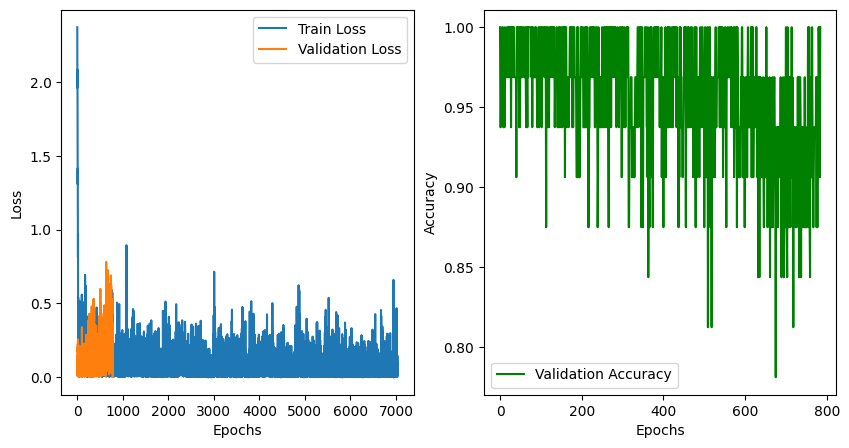

In [49]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

model = ResNetTransferLearningModel("data/cifar10/", 32, 1e-3)

trainer = pl.Trainer(
    callbacks=[checkpoint_callback], max_epochs=5, num_sanity_val_steps=0
)
trainer.fit(model)

In [50]:
# Evaluate the model on the test set
trainer.test(model=model, dataloaders=model.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:02<00:00, 126.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8133999705314636     │
│         test_loss         │    0.8595882654190063     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8595882654190063, 'test_accuracy': 0.8133999705314636}]